In [8]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [9]:
file_path = r'covid_19_data.csv'
raw_data = pd.read_csv(file_path)

In [10]:
raw_data['ObservationDate'] = pd.to_datetime(raw_data['ObservationDate'])
data = raw_data.groupby(['Country/Region', 'ObservationDate'], as_index=False)[['Confirmed', 'Deaths', 'Recovered']].sum()

def prepare_country_data(country_name, population):
    country_data = data[data['Country/Region'] == country_name]
    susceptible = population - country_data['Confirmed'].values - country_data['Recovered'].values
    infected = country_data['Confirmed'].values - country_data['Recovered'].values
    recovered = country_data['Recovered'].values
    return country_data['ObservationDate'].values, susceptible, infected, recovered

In [11]:
def sir_model(y, t, beta, gamma):
    S, I, R = y
    N = S + I + R
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def run_sir_model(S0, I0, R0, beta, gamma, days):
    N = S0 + I0 + R0
    t = np.linspace(0, days, days)
    result = odeint(sir_model, [S0, I0, R0], t, args=(beta, gamma))
    S, I, R = result.T
    return t, S, I, R

# Дані для Італії
italy_population = 60360000
dates_italy, S_italy, I_italy, R_italy = prepare_country_data('Italy', italy_population)

# Дані для Франції
france_population = 65270000
dates_france, S_france, I_france, R_france = prepare_country_data('France', france_population)

# Початкові параметри
beta_italy = 0.4
gamma_italy = 0.1
beta_france = 0.35
gamma_france = 0.1

# Прогноз на 7, 30 та 300 днів
days_to_predict = [7, 30, 300]

# Функція для прогнозу та виведення результатів
def predict_and_display(country, S0, I0, R0, beta, gamma, days_list):
    print(f"\nПрогноз для {country}:")
    results = {}
    for days in days_list:
        t, S, I, R = run_sir_model(S0, I0, R0, beta, gamma, days)
        results[days] = (t, S, I, R)
        print(f"На {days} день:")
        print(f" - Інфіковані: {int(I[-1])}")
        print(f" - Одужалі: {int(R[-1])}")
        print(f" - Померлі: {int((S0 + I0 + R0) - (S[-1] + I[-1] + R[-1]))}")
        
        # Побудова графіка
        plt.plot(t, I, label=f'{country} - Infected ({days} днів)')
        plt.plot(t, R, label=f'{country} - Recovered ({days} днів)')
    plt.title(f'Прогноз COVID-19 для {country}')
    plt.xlabel('Дні')
    plt.ylabel('Кількість людей')
    plt.legend()
    plt.grid()
    plt.show()
    return results


Прогноз для Italy:
На 7 день:
 - Інфіковані: 16
 - Одужалі: 4
 - Померлі: 0
На 30 день:
 - Інфіковані: 16198
 - Одужалі: 5400
 - Померлі: 0
На 300 день:
 - Інфіковані: 0
 - Одужалі: 59163218
 - Померлі: 0


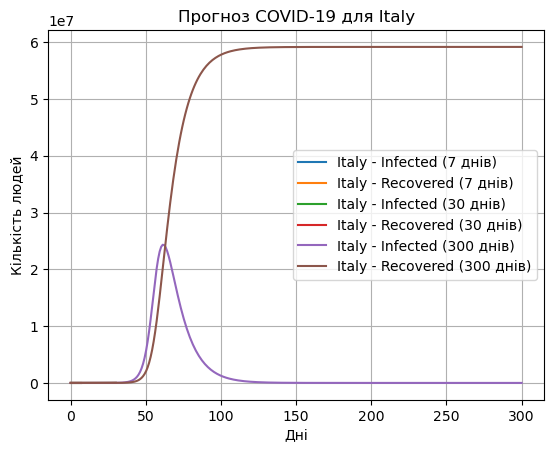

In [12]:
results_italy = predict_and_display('Italy', S_italy[0], I_italy[0], R_italy[0], beta_italy, gamma_italy, days_to_predict)



Прогноз для France:
На 7 день:
 - Інфіковані: 11
 - Одужалі: 3
 - Померлі: 0
На 30 день:
 - Інфіковані: 3615
 - Одужалі: 1445
 - Померлі: 0
На 300 день:
 - Інфіковані: 0
 - Одужалі: 63049825
 - Померлі: 0


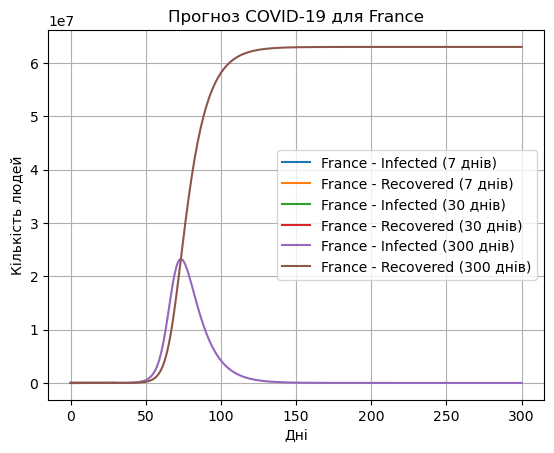

In [13]:
results_france = predict_and_display('France', S_france[0], I_france[0], R_france[0], beta_france, gamma_france, days_to_predict)


In [14]:
def find_peak_infected(I_pred, t):
    peak_index = np.argmax(I_pred)
    return t[peak_index], I_pred[peak_index]

peak_day_italy, peak_infected_italy = find_peak_infected(results_italy[300][2], results_italy[300][0])
peak_day_france, peak_infected_france = find_peak_infected(results_france[300][2], results_france[300][0])

print(f"Пік інфікованих в Італії: день {int(peak_day_italy)}, {int(peak_infected_italy)} осіб")
print(f"Пік інфікованих у Франції: день {int(peak_day_france)}, {int(peak_infected_france)} осіб")

# Дата завершення епідемії (коли I ≈ 0)

Пік інфікованих в Італії: день 61, 24326231 осіб
Пік інфікованих у Франції: день 73, 23257728 осіб


In [15]:
def find_end_of_epidemic(I_pred, threshold=1):
    end_index = np.where(I_pred < threshold)[0]
    if len(end_index) > 0:
        return end_index[0]
    return None

end_day_italy = find_end_of_epidemic(results_italy[300][2])
end_day_france = find_end_of_epidemic(results_france[300][2])

print(f"Епідемія в Італії закінчиться приблизно на день {end_day_italy}")
print(f"Епідемія у Франції закінчиться приблизно на день {end_day_france}")


Епідемія в Італії закінчиться приблизно на день 252
Епідемія у Франції закінчиться приблизно на день 273
